In [21]:
num_epochs_base = 700
lr = 0.001
num_hidden = 16

Epoch 1, Loss: 1.9463, Train Acc: 0.1714
Val Acc: 0.0980
Epoch 2, Loss: 1.9452, Train Acc: 0.1857
Val Acc: 0.1360
Epoch 3, Loss: 1.9444, Train Acc: 0.2071
Val Acc: 0.1920
Epoch 4, Loss: 1.9433, Train Acc: 0.3000
Val Acc: 0.2660
Epoch 5, Loss: 1.9432, Train Acc: 0.3357
Val Acc: 0.3120
Epoch 6, Loss: 1.9423, Train Acc: 0.3357
Val Acc: 0.3500
Epoch 7, Loss: 1.9416, Train Acc: 0.4214
Val Acc: 0.3780
Epoch 8, Loss: 1.9405, Train Acc: 0.4857
Val Acc: 0.4220
Epoch 9, Loss: 1.9393, Train Acc: 0.5071
Val Acc: 0.4760
Epoch 10, Loss: 1.9383, Train Acc: 0.5929
Val Acc: 0.4740
Epoch 11, Loss: 1.9379, Train Acc: 0.6071
Val Acc: 0.5040
Epoch 12, Loss: 1.9368, Train Acc: 0.6071
Val Acc: 0.5180
Epoch 13, Loss: 1.9351, Train Acc: 0.6000
Val Acc: 0.5240
Epoch 14, Loss: 1.9344, Train Acc: 0.6286
Val Acc: 0.5220
Epoch 15, Loss: 1.9341, Train Acc: 0.6857
Val Acc: 0.5280
Epoch 16, Loss: 1.9323, Train Acc: 0.6500
Val Acc: 0.5280
Epoch 17, Loss: 1.9309, Train Acc: 0.6643
Val Acc: 0.5420
Epoch 18, Loss: 1.9304,

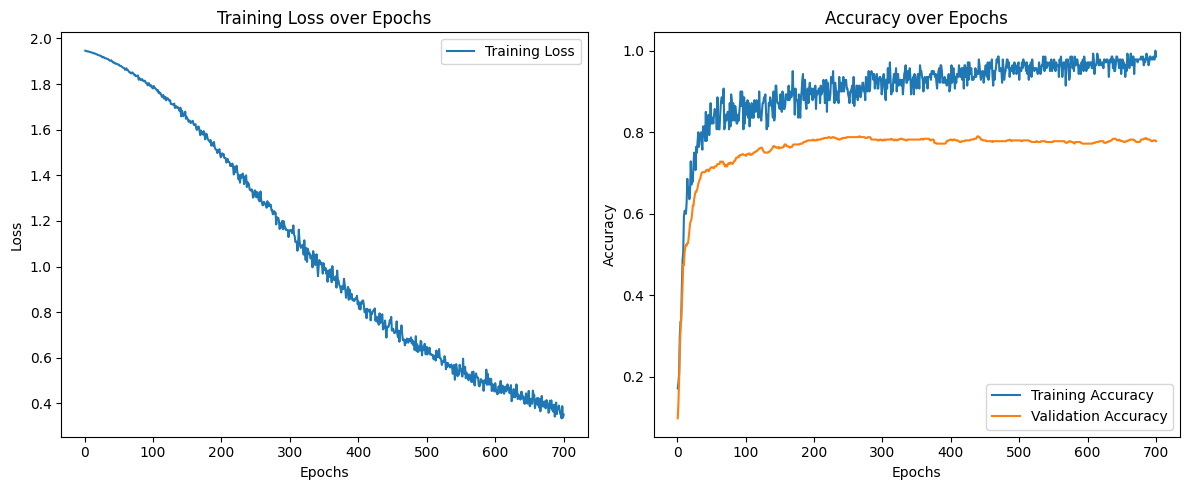

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt

# Define the GCN model
class GCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Load the Cora dataset
path = './data/Cora'
transform = T.Compose([T.NormalizeFeatures()])
dataset = Planetoid(path, name='Cora', transform=transform)[0]

# Number of features and classes for the Cora dataset
num_features = 1433
num_classes = 7

# Initialize the DataLoader
train_loader = DataLoader([dataset], batch_size=1, shuffle=True)
val_loader = DataLoader([dataset], batch_size=1, shuffle=False)

# Training and validation functions
def train(model, optimizer, train_loader, device, epoch, distillate=False, teacher=None):
    model.train()
    total_loss = 0
    correct = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = F.nll_loss(out[dataset.train_mask], data.y[dataset.train_mask])
        ##############################################################################################
        if distillate and teacher is not None:
            with torch.no_grad():
                teacher_out = teacher(data)
            loss += F.mse_loss(out[dataset.train_mask], teacher_out[dataset.train_mask])
        ##############################################################################################
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
        pred = out[dataset.train_mask].argmax(dim=1)
        correct += pred.eq(data.y[dataset.train_mask]).sum().item()
    train_acc = correct / dataset.train_mask.sum().item()
    print(f'Epoch {epoch}, Loss: {total_loss:.4f}, Train Acc: {train_acc:.4f}')
    return total_loss / len(train_loader.dataset), train_acc

def validate(model, val_loader, device):
    model.eval()
    correct = 0
    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)
            out = model(data)
            pred = out[dataset.val_mask].argmax(dim=1)
            correct += pred.eq(data.y[dataset.val_mask]).sum().item()
    val_acc = correct / dataset.val_mask.sum().item()
    print(f'Val Acc: {val_acc:.4f}')
    return val_acc

# Initialize the model and optimizer for Stage 1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
base_model = GCN(num_features, num_hidden, num_classes).to(device)
optimizer = torch.optim.Adam(base_model.parameters(), lr=lr, weight_decay=1e-5)

# Training the base model for 200 epochs
train_losses = []
train_accuracies = []
val_accuracies = []

epochs = range(1, num_epochs_base+1)

for epoch in epochs:
    loss, train_acc = train(base_model, optimizer, train_loader, device, epoch)
    val_acc = validate(base_model, val_loader, device)
    train_losses.append(loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

# Plotting the training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


Stage 1: Real-valued and Real-weighted Network

In [71]:
train_losses1 = []
train_accuracies1 = []
val_accuracies1 = []
# Define the student model for Stage 1 (replace quantization with tanh)
class StudentGCNStage1(GCN):
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.tanh(x)  # Use tanh instead of ReLU
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Initialize the student model and optimizer for Stage 1
student_stage1 = StudentGCNStage1(num_features, num_hidden, num_classes).to(device)
student_stage1.load_state_dict(base_model.state_dict())  # Distill weights from base model
optimizer_stage1 = torch.optim.Adam(student_stage1.parameters(), lr=lr, weight_decay=1e-5)

# Training the student model for Stage 1
for epoch in epochs:
    loss, train_acc = train(student_stage1, optimizer_stage1, train_loader, device, epoch, distillate=True, teacher=base_model)
    val_acc = validate(student_stage1, val_loader, device)
    train_losses1.append(loss)
    train_accuracies1.append(train_acc)
    val_accuracies1.append(val_acc)
print(len(train_losses1))

Epoch 1, Loss: 0.9914, Train Acc: 0.9857
Val Acc: 0.7780
Epoch 2, Loss: 0.9412, Train Acc: 0.9786
Val Acc: 0.7780
Epoch 3, Loss: 0.9097, Train Acc: 0.9714
Val Acc: 0.7780
Epoch 4, Loss: 0.9076, Train Acc: 0.9643
Val Acc: 0.7780
Epoch 5, Loss: 0.9616, Train Acc: 0.9714
Val Acc: 0.7780
Epoch 6, Loss: 0.8966, Train Acc: 0.9786
Val Acc: 0.7780
Epoch 7, Loss: 0.8777, Train Acc: 0.9643
Val Acc: 0.7780
Epoch 8, Loss: 1.0270, Train Acc: 0.9929
Val Acc: 0.7780
Epoch 9, Loss: 0.9833, Train Acc: 0.9786
Val Acc: 0.7780
Epoch 10, Loss: 0.8845, Train Acc: 0.9857
Val Acc: 0.7780
Epoch 11, Loss: 0.8217, Train Acc: 0.9643
Val Acc: 0.7780
Epoch 12, Loss: 0.9561, Train Acc: 0.9929
Val Acc: 0.7780
Epoch 13, Loss: 0.9292, Train Acc: 0.9714
Val Acc: 0.7780
Epoch 14, Loss: 0.8558, Train Acc: 0.9786
Val Acc: 0.7780
Epoch 15, Loss: 0.8408, Train Acc: 0.9786
Val Acc: 0.7780
Epoch 16, Loss: 0.9165, Train Acc: 0.9571
Val Acc: 0.7780
Epoch 17, Loss: 0.7657, Train Acc: 0.9929
Val Acc: 0.7780
Epoch 18, Loss: 0.8042,

In [72]:
train_losses2 = []
train_accuracies2 = []
val_accuracies2 = []


# Define the student model for Stage 2 (binary activations)
class StudentGCNStage2(GCN):
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = (x > 0).float() * 2 - 1  # Binary activations
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Initialize the student model and optimizer for Stage 2
student_stage2 = StudentGCNStage2(num_features, num_hidden, num_classes).to(device)
student_stage2.load_state_dict(student_stage1.state_dict())  # Distill weights from Stage 1 model
optimizer_stage2 = torch.optim.Adam(student_stage2.parameters(), lr=lr*0.25, weight_decay=1e-5)  # Smaller learning rate

# Training the student model for Stage 2
for epoch in epochs:
    loss, train_acc = train(student_stage2, optimizer_stage2, train_loader, device, epoch, distillate=True, teacher=student_stage1)
    val_acc = validate(student_stage2, val_loader, device)
    train_losses2.append(loss)
    train_accuracies2.append(train_acc)
    val_accuracies2.append(val_acc)


Epoch 1, Loss: 173.7483, Train Acc: 0.9929
Val Acc: 0.7380
Epoch 2, Loss: 170.2166, Train Acc: 1.0000
Val Acc: 0.7380
Epoch 3, Loss: 175.7829, Train Acc: 1.0000
Val Acc: 0.7380
Epoch 4, Loss: 166.8649, Train Acc: 1.0000
Val Acc: 0.7380
Epoch 5, Loss: 177.7746, Train Acc: 1.0000
Val Acc: 0.7380
Epoch 6, Loss: 179.3989, Train Acc: 0.9929
Val Acc: 0.7380
Epoch 7, Loss: 176.7846, Train Acc: 1.0000
Val Acc: 0.7380
Epoch 8, Loss: 166.2416, Train Acc: 1.0000
Val Acc: 0.7380
Epoch 9, Loss: 171.3717, Train Acc: 1.0000
Val Acc: 0.7380
Epoch 10, Loss: 173.9562, Train Acc: 1.0000
Val Acc: 0.7380
Epoch 11, Loss: 170.9556, Train Acc: 1.0000
Val Acc: 0.7380
Epoch 12, Loss: 163.0116, Train Acc: 1.0000
Val Acc: 0.7380
Epoch 13, Loss: 171.6429, Train Acc: 1.0000
Val Acc: 0.7380
Epoch 14, Loss: 170.8333, Train Acc: 1.0000
Val Acc: 0.7380
Epoch 15, Loss: 166.7144, Train Acc: 1.0000
Val Acc: 0.7380
Epoch 16, Loss: 165.8848, Train Acc: 1.0000
Val Acc: 0.7380
Epoch 17, Loss: 171.7396, Train Acc: 1.0000
Val A

Epoch 1, Loss: 5.7689, Train Acc: 1.0000
Val Acc: 0.7420
Epoch 2, Loss: 6.1167, Train Acc: 1.0000
Val Acc: 0.7420
Epoch 3, Loss: 5.4274, Train Acc: 1.0000
Val Acc: 0.7420
Epoch 4, Loss: 5.4507, Train Acc: 1.0000
Val Acc: 0.7420
Epoch 5, Loss: 4.5007, Train Acc: 1.0000
Val Acc: 0.7420
Epoch 6, Loss: 5.9037, Train Acc: 0.9929
Val Acc: 0.7420
Epoch 7, Loss: 5.4785, Train Acc: 1.0000
Val Acc: 0.7420
Epoch 8, Loss: 5.2164, Train Acc: 0.9929
Val Acc: 0.7420
Epoch 9, Loss: 4.7684, Train Acc: 0.9929
Val Acc: 0.7420
Epoch 10, Loss: 5.7099, Train Acc: 0.9929
Val Acc: 0.7420
Epoch 11, Loss: 4.6890, Train Acc: 1.0000
Val Acc: 0.7420
Epoch 12, Loss: 4.5345, Train Acc: 1.0000
Val Acc: 0.7420
Epoch 13, Loss: 5.1175, Train Acc: 1.0000
Val Acc: 0.7420
Epoch 14, Loss: 5.3566, Train Acc: 1.0000
Val Acc: 0.7420
Epoch 15, Loss: 5.5889, Train Acc: 1.0000
Val Acc: 0.7420
Epoch 16, Loss: 4.6301, Train Acc: 1.0000
Val Acc: 0.7420
Epoch 17, Loss: 5.2417, Train Acc: 0.9929
Val Acc: 0.7420
Epoch 18, Loss: 5.6403,

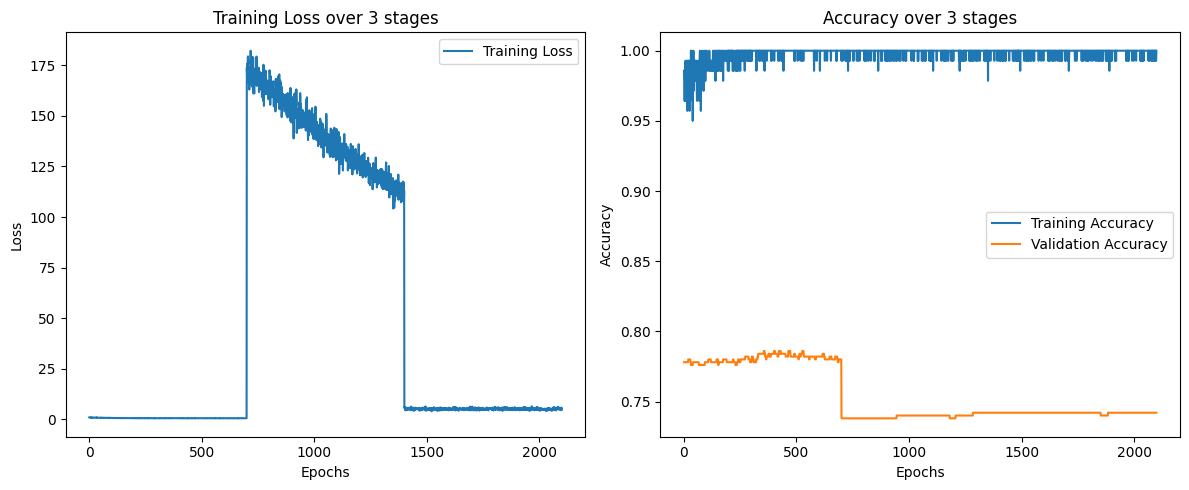

In [73]:
import matplotlib.pyplot as plt


train_losses3 = []
train_accuracies3 = []
val_accuracies3 = []



# Define custom GCNConv layer to handle latent weights
class BinaryGCNConv(GCNConv):
    def __init__(self, in_channels, out_channels):
        super(BinaryGCNConv, self).__init__(in_channels, out_channels)
        self.latent_weight = nn.Parameter(torch.empty(self.out_channels, self.in_channels))
        nn.init.xavier_uniform_(self.latent_weight)  # Initialize weights explicitly

    def forward(self, x, edge_index, edge_weight=None):
        weight_bin = (self.latent_weight > 0).float() * 2 - 1
        self.weight = nn.Parameter(weight_bin)  # Assign the binary weights to self.weight
        return super(BinaryGCNConv, self).forward(x, edge_index, edge_weight)  # Call the parent forward method

    def message(self, x_j, edge_weight):
        if edge_weight is None:
            return x_j
        else:
            return edge_weight.view(-1, 1) * x_j


# Define the custom GCN model with binary weights
class BinaryGCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(BinaryGCN, self).__init__()
        self.conv1 = BinaryGCNConv(in_channels, hidden_channels)
        self.conv2 = BinaryGCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = (x > 0).float() * 2 - 1  # Binary activations
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)







# Initialize the student model and optimizer for Stage 3
#student_stage3 = BinaryGCN(num_features, num_hidden, num_classes).to(device)
#student_stage3.load_state_dict(student_stage2.state_dict())  # Distill weights from Stage 2 model
# Initialize the student model for Stage 3
student_stage3 = BinaryGCN(num_features, num_hidden, num_classes).to(device)

# Load the state dictionary from student_stage2 (default weights)
state_dict = student_stage2.state_dict()
student_stage3.load_state_dict(state_dict, strict=False)  # Allow mismatched keys

# Manually update latent_weight for each BinaryGCNConv layer
with torch.no_grad():
    student_stage3.conv1.latent_weight.copy_(student_stage3.conv1.lin.weight.clone().detach())
    student_stage3.conv2.latent_weight.copy_(student_stage3.conv2.lin.weight.clone().detach())






optimizer_stage3 = torch.optim.Adam(student_stage3.parameters(), lr=lr*0.25, weight_decay=0)  # No weight decay

# Training the student model for Stage 3
for epoch in epochs:
    loss, train_acc = train(student_stage3, optimizer_stage3, train_loader, device, epoch, distillate=True, teacher=student_stage2)
    val_acc = validate(student_stage3, val_loader, device)
    train_losses3.append(loss)
    train_accuracies3.append(train_acc)
    val_accuracies3.append(val_acc)





# Combine all epochs into one list
total_epochs = 3 * num_epochs_base
print(len(train_losses1))
print(len(train_losses2))
print(len(train_losses3))
print(len(train_losses))
# Ensure lengths of the lists match
train_losses = train_losses1 + train_losses2 + train_losses3
train_accuracies = train_accuracies1 + train_accuracies2 + train_accuracies3
val_accuracies = val_accuracies1 + val_accuracies2 + val_accuracies3

plt.figure(figsize=(12, 5))

# Plot the loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over 3 stages')
plt.legend()

# Plot the accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over 3 stages')
plt.legend()

plt.tight_layout()
plt.show()
